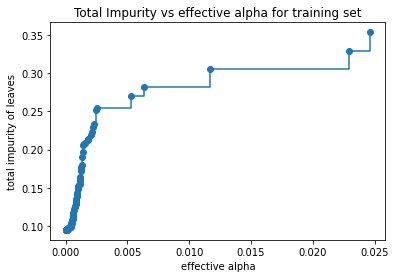

[3.469446951953614e-18, 4.70448748660264e-06, 2.4458622426232722e-05, 6.629045648930826e-05, 6.827583602700849e-05, 7.022257678867324e-05, 7.172023933396622e-05, 7.761250800232631e-05, 8.228708876844807e-05, 9.285578580125672e-05, 0.00017633605584446653, 0.00021406397277808097, 0.00021667803021149096, 0.0002665544332211016, 0.00028270188854130087, 0.0002827018885413063, 0.00039121372454706076, 0.0004262231674736559, 0.00044881574533925665, 0.00045977092205802994, 0.00048702713844263855, 0.0004881757432675677, 0.0004997255605528146, 0.0005057712014077793, 0.0005633009435290854, 0.000581298787576821, 0.0005877014333905053, 0.0005913087310126927, 0.0005989639897583714, 0.0006130961354841994, 0.0006485689345952362, 0.0006944444444444497, 0.0007880220646178232, 0.0007945346758132023, 0.0008250825082508273, 0.0008518334437817609, 0.000853487297987187, 0.0008573388203017893, 0.0008675342008675487, 0.0008834733434833503, 0.0008860805461742456, 0.000925402745414361, 0.0009416195856873895, 0.000

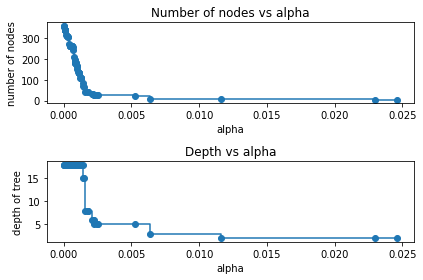

In [75]:
import pandas as pd

import time
from sklearn import tree
import pydot
import matplotlib.pyplot as plt
import math as math

train = pd.read_csv("https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/test.csv")


def embarked(val): 
    if val=='C': 
        return 1
    elif val=='S':
        return 2
    elif val=='Q':
        return 3
    else: 
        return 0

def cabin(val):
  cabinval = 0
  if type(val)==str:
      floor = val[0]
      res = [int(i) for i in val[1:].split() if i.isdigit()] 
      loc = 0
      if len(res) > 0:
         loc = int(res[0])
      cabinval = ord(floor)
      cabinval=cabinval*1000
      cabinval = cabinval + loc
  return cabinval

#chainging strings to numerical value

result = test[['Name','PassengerId']]

train['sex'] = train["Sex"].apply(lambda x: 0 if x == "male" else 1)
test['sex'] = test["Sex"].apply(lambda x: 0 if x == "male" else 1)

train['embarked'] = train['Embarked'].apply(embarked)
test['embarked'] = test['Embarked'].apply(embarked)

train['cabin'] = train['Cabin'].apply(cabin)
test['cabin'] = test['Cabin'].apply(cabin)

#Age is an important factor but unfortuantely, the dataset contains empty values for age
#So we will fill it up with average age of the passengers. 
average = train.mean(skipna=True, numeric_only=True, axis=0)
average_age = average['Age'];
train['age'] = train['Age'].apply(lambda x: x if ((type(x)== float or type(x)== int) and not math.isnan(x)) else average_age)
test['age'] = test['Age'].apply(lambda x: x if ((type(x)== float or type(x)== int) and not math.isnan(x)) else average_age)

#dropping unwanted columns
train = train.drop(['Embarked','Cabin','Ticket','Sex','Name','PassengerId','Age','Fare','embarked'],axis=1)
test = test.drop(['Embarked','Cabin','Ticket','Sex','Name','PassengerId','Age','Fare','embarked'],axis=1)

x_train = train.iloc[:,1:].values
y_train = train.iloc[:,0].values
x_test = test.iloc[:,:].values

#clf = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=4, class_weight="balanced");
clf = tree.DecisionTreeClassifier(random_state=0, class_weight="balanced");
#clf = tree.DecisionTreeClassifier(min_samples_split=4, max_features="auto", max_leaf_nodes=20);
clf = clf.fit(x_train, y_train)
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()
  
ccp_alphas = [x for x in ccp_alphas if x > 0.0]
print(ccp_alphas)
clfs = []
for ccp_alpha in ccp_alphas:
    if ccp_alpha > 0.0:
      clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
      clf.fit(x_train, y_train)
      clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(x_train, y_train) for clf in clfs]

#test_scores = [clf.score(x_test, y_test) for clf in clfs]
clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.003)
clf.fit(x_train, y_train)

y_predict = clf.predict(x_test);
print("before appending result ")
print(result)

print("after appending result")
result["Survived"]=y_predict;

print(result);

result[['PassengerId','Survived']].to_csv('result.csv',index=False)


